In [ ]:
# for preprocess text
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import gensim
from IPython.display import display, HTML
from nltk.corpus import wordnet

from gensim.parsing.preprocessing import remove_stopwords


In [ ]:
#Preprocess corpus

def preProcess(text):
    # should return a list of tokens
    
    # word tokenisation, including punctuation removal
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # lowercasing
    tokens = [t.lower() for t in tokens]

    # stopword removal- benefits are it removes rare words, though bad for bigram relations
    stop = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop]
    
    # lemmatisation
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t] # ensure no empty space

    # remove numbers
    digits = '0123456789'
    text = [t for t in text if t not in digits]
    
    return tokens

In [ ]:
def create_bigrams(words):
    bigram = gensim.models.Phrases(words, min_count=2, threshold=30)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

import data file

In [ ]:
filename = "final_result.csv"

In [ ]:
data = pd.read_csv(filename, sep=",", error_bad_lines=False, encoding='latin-1')

In [ ]:
data['Dominant_Topic'].value_counts()

Staff, Location        76655
Location               69724
Comfort, Clealiness    66165
Facilities             65110
Location, Food         60040
Food                   52864
Staff                  50760
Service                47183
Price                  31197
Name: Dominant_Topic, dtype: int64

In [ ]:
#Choose subgroup
topic = 'Comfort, Clealiness'

In [ ]:
data2 = data[data.Dominant_Topic == topic]

Preprocess corpus

In [ ]:
#Preprocess data and apply bi-gram
data2['processed'] = data2['Text'].apply(preProcess)
x_raw = data2['processed'].values.tolist()

bigram_mod = create_bigrams(x_raw)
x = [bigram_mod[line] for line in x_raw]

x_train = [' '.join(i) for i in x]

Prepare dictionary and variable

In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras_preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(x_train)

# create dictionary mapping words with ids
word2idx = tokenizer.word_index
word2idx['PAD'] = 0

# create dictionary mapping ids with words
idx2word = {v:k for k, v in word2idx.items()}
word_ids = [[word2idx[w] for w in text.text_to_word_sequence(doc)] for doc in x_train]


vocab_size = len(word2idx) + 1
embed_size = 100

Build skip-gram

In [ ]:
from keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=5) for wid in word_ids]

In [ ]:
print(len(skip_grams))

66165


In [ ]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(len(pairs)):
    print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(idx2word[pairs[i][0]], pairs[i][0], idx2word[pairs[i][1]], pairs[i][1], labels[i]))

(price (48), ideal (310)) -> 1
(soft (69), terible (11449)) -> 0
(food (74), appreciably (15094)) -> 0
(tiny (66), tempted (7230)) -> 0
(separate (259), bath (10)) -> 1
(helpful (17), westminster (1655)) -> 1
(course (1088), everything (41)) -> 1
(large (33), shower (18)) -> 1
(accessible (910), helpful (17)) -> 1
(star (186), opener (4184)) -> 0
(price (48), salad (3399)) -> 1
(course (1088), faciliites (10673)) -> 0
(22 (1955), crampt (11542)) -> 0
(corinthia (5019), ground (583)) -> 0
(touring (3231), alisha (13123)) -> 0
(soft (69), quiet (21)) -> 0
(restaurant (57), excellant (2374)) -> 0
(towel (136), fluffy (502)) -> 1
(shower (18), vallet (9236)) -> 0
(sink (460), burst (8024)) -> 0
(helpful (17), deliberately (16559)) -> 0
(location (3), course (1088)) -> 1
(sink (460), amazying (15799)) -> 0
(nothing (34), deliver (2423)) -> 0
(course (1088), price (48)) -> 1
(corinthia (5019), equipted (6992)) -> 0
(clean (7), soft (69)) -> 1
(five (881), bed (1)) -> 1
(everything (41), towe

Define neural network model

In [ ]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

#skip gram model
target_word = Input((1,), dtype='int32')
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer', embeddings_initializer='glorot_uniform', input_length=1)(target_word)
target_input = Reshape((embed_size, ))(target_embedding)

context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer', embeddings_initializer="glorot_uniform", input_length=1)(context_word)
context_input = Reshape((embed_size,))(context_embedding)

merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

label = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(merged_inputs)
model = Model(inputs=[target_word, context_word], outputs=[label])

In [ ]:
model.compile(loss="mean_squared_error", optimizer="rmsprop")


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1779500     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1779500     input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

Train model with 5 epochs

In [ ]:
import numpy as np

for epoch in range(1, 6):
    epoch_loss = 0
# in each epoch, train all the sentences, one per iteration=> batch_size = num_sents 
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32') 
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32') 
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 10000 == 0: # after 5000 sentences i.e. 5000 iterations
            print('Processed %d sentences' %i) 
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i) 
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')


Processed 0 sentences
Processed 10000 sentences
Processed 20000 sentences
Processed 30000 sentences
Processed 40000 sentences
Processed 50000 sentences
Processed 60000 sentences
Processed all 66164 sentences
Epoch: 1 Loss: 5085.650658641267 

Processed 0 sentences
Processed 10000 sentences
Processed 20000 sentences
Processed 30000 sentences
Processed 40000 sentences
Processed 50000 sentences
Processed 60000 sentences
Processed all 66164 sentences
Epoch: 2 Loss: 4636.22439676375 

Processed 0 sentences
Processed 10000 sentences
Processed 20000 sentences
Processed 30000 sentences
Processed 40000 sentences
Processed 50000 sentences
Processed 60000 sentences
Processed all 66164 sentences
Epoch: 3 Loss: 4444.316936118413 

Processed 0 sentences
Processed 10000 sentences
Processed 20000 sentences
Processed 30000 sentences
Processed 40000 sentences
Processed 50000 sentences
Processed 60000 sentences
Processed all 66164 sentences
Epoch: 4 Loss: 4289.915264105593 

Processed 0 sentences
Process

Extract word embeddings

In [ ]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:]

In [ ]:
print(word_embeddings.shape)

(17794, 100)


Visualisation of result

In [ ]:
from keras.models import load_model

model.save('Comfort_Clean_word2vec.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [ ]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                   0         1         2   ...        97        98        99
bed          0.067161 -0.047256  0.047344  ...  0.048129  0.217887  0.015424
small        0.188023  0.009104  0.027692  ... -0.036829  0.020555  0.046946
location     0.098530 -0.141801  0.057068  ...  0.018724  0.030454  0.018644
staff        0.002920 -0.062912  0.073593  ... -0.010909  0.098529  0.067371
comfortable  0.025763 -0.037600  0.037774  ...  0.059209  0.090132  0.060228
room         0.181153 -0.061635  0.242890  ...  0.077662  0.064758  0.059084
clean       -0.077296  0.096020  0.035707  ...  0.100448  0.059949 -0.036807
nice         0.040264  0.139653  0.101421  ...  0.031738  0.043361  0.053964
breakfast    0.113810  0.000658  0.101880  ...  0.098837 -0.052759  0.051074
bath         0.091804 -0.048721  0.072903  ...  0.075139  0.179988  0.168084

[10 rows x 100 columns]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)

print(similarity_matrix.shape)

(28410, 28410)


In [ ]:
search_terms = ['price']
similar_words = {term: [idx2word[idx] for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1] for term in search_terms}
print(similar_words)

{'price': ['rate', 'expensive', 'paid', 'quite', 'considering']}


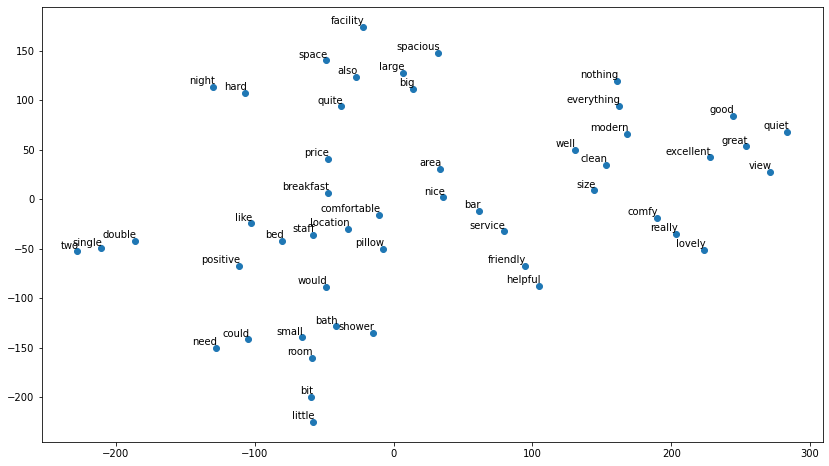

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')